In [1]:
%run training_functions.ipynb

/home/ac.cdavies/.vnv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-04-11 17:30:48.847512: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744392648.862670 2261509 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744392648.867252 2261509 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744392648.879779 2261509 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 

{'record': Value(dtype='string', id=None), 'text': Value(dtype='string', id=None)}
{'text': Value(dtype='string', id=None)}
{'text': Value(dtype='string', id=None)}
['train', 'validation', 'test']
['train', 'validation', 'test']
In, Out, get_ipython, exit, quit, open, accelerate, datasets, evaluate, math, np, peft, pickle, pytest, ipytest, pd, transformers, torch, load_dataset, load_dataset_builder, get_dataset_split_names, get_dataset_config_names, LoftQConfig, LoraConfig, get_peft_model, AutoModelForCausalLM, AutoTokenizer, pipeline, TrainingArguments, Trainer, SFTTrainer, SFTConfig, @py_builtins, @pytest_ar, model_from_pkl, ds_builder1, ds_builder2, ds_builder3, ds_gs, ds_gst1_train, ds_gst1_test, ds_gst2_train, ds_gst2_test, search_with_strings, map_data, print_trainable_parameters, metric, comp_metrics_output, compute_metrics, make_trainer, get_dataframe, get_training_output, 

## Imported Functions
1. model_from_pkl(model): extracts ML model from pkl file
2. map_data(data, model, tokenizer): performs preprocessing/tokenization on data
3. make_trainer(m_model, train_data, test_data, config, args): creates training object with model, training arguments, train/test data, a configuration, and evaluation function
4. compute_metrics(eval_pred): used in the trainer, calculates prediction accuracy/validation loss
5. get_training_output(trainer, keys: list): extracts data from training logs
6. get_dataframe(training_output: list, strategy): used in get_training_output, puts training data into dataframe/graph form

In [2]:
lla_321, lla_321_tokenizer=model_from_pkl("Llama-3.2-1B-Instruct")

In [3]:
lla_323, lla_323_tokenizer=model_from_pkl("Llama-3.2-3B-Instruct")

In [4]:
l_tokenized_genome_samples=map_data(ds_gs, lla_321, lla_321_tokenizer)

In [5]:
l_tokenized_stage1_train=map_data(ds_gst1_train, lla_321, lla_321_tokenizer)
l_tokenized_stage1_test=map_data(ds_gst1_test, lla_321, lla_321_tokenizer)

In [6]:
l_tokenized_stage2_train=map_data(ds_gst2_train, lla_321, lla_321_tokenizer)
l_tokenized_stage2_test=map_data(ds_gst2_test, lla_321, lla_321_tokenizer)

In [7]:
# to fine-tune with LoRA, instantiate a base model (as above)
# create LoraConfig where LoRA-specific parameters are defined
config=LoraConfig(
    #inference_mode=False,
    r=8, #rank of update matrices, lower value results in smaller matrices with fewer parameters
    lora_alpha=16, #LoRA scaling factor
    task_type="CAUSAL_LM",
    lora_dropout=0.1, # dropout probability of LoRA layers
    bias="none", # specifies if bias parameters should be trained
    #modules_to_save=["decode_head"] #models apart from LoRA layers that are trainable
)

In [8]:
lla_lora_model=get_peft_model(lla_321, config)
print_trainable_parameters(lla_lora_model)

trainable params: 851968 || all params: 1236666368 || trainable%: 0.07


In [9]:
l_trainer = make_trainer(lla_lora_model, l_tokenized_stage1_train, l_tokenized_stage1_test, config,
                          SFTConfig(output_dir="test_trainer", eval_strategy="steps",
                                    logging_strategy="steps",
                                    logging_steps=6))

In [10]:
#l_trainer.train() 

In [11]:
# output=get_training_output(l_trainer, ['loss', 'eval_loss', 'eval_accuracy'])
# output

In [12]:
l2_trainer=make_trainer(lla_lora_model, l_tokenized_stage1_train, l_tokenized_stage1_test, config,
                          SFTConfig(output_dir="test_trainer", eval_strategy="epoch",
                                    logging_strategy="steps",
                                    logging_steps=2))

In [13]:
l2_trainer.train() #same arguments as m_trainer

/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.660500,2.663464,0.000869
2,0.658600,2.641293,0.000986
3,0.663700,2.635126,0.000908


/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


TrainOutput(global_step=96, training_loss=0.6673067063093185, metrics={'train_runtime': 2286.3156, 'train_samples_per_second': 1.312, 'train_steps_per_second': 0.042, 'total_flos': 1.795273261056e+16, 'train_loss': 0.6673067063093185})

,loss,eval_loss,eval_accuracy
epoch,,,
1.0,0.6605,2.663464,0.000869
2.0,0.6586,2.641293,0.000986
3.0,0.6637,2.635126,0.000908


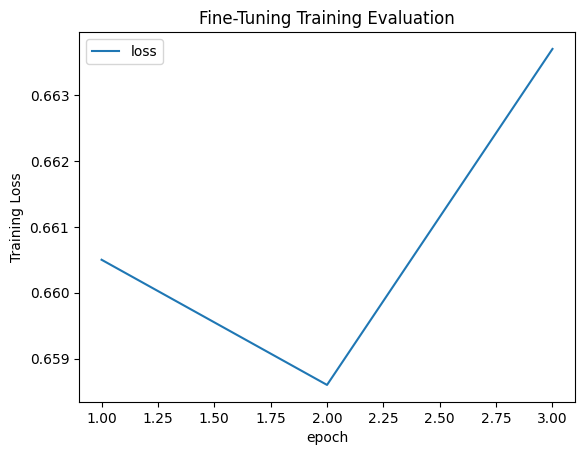

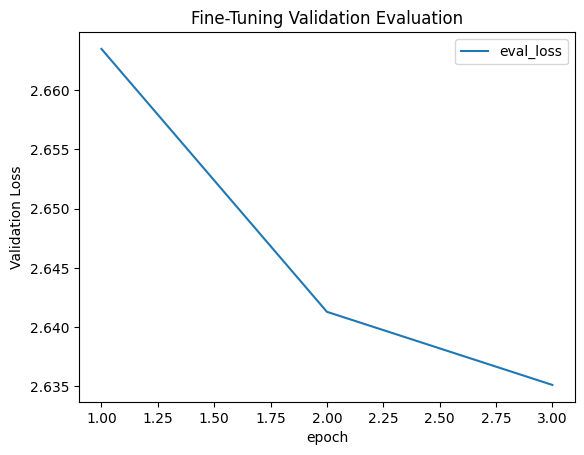

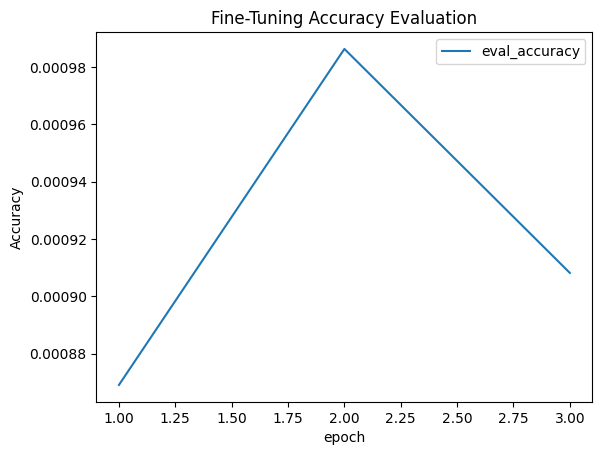

In [14]:
output=get_training_output(l2_trainer, ['loss', 'eval_loss', 'eval_accuracy'])
output

In [15]:
#l_trainer.model.save_pretrained('./fine_tuned/lla/')
l2_trainer.model.save_pretrained('./fine_tuned/lla2/')

In [16]:
#l_trainer.processing_class.save_pretrained('./fine_tuned/lla_token/')
l2_trainer.processing_class.save_pretrained('./fine_tuned/lla2_token/')

('./fine_tuned/lla2_token/tokenizer_config.json',
 './fine_tuned/lla2_token/special_tokens_map.json',
 './fine_tuned/lla2_token/tokenizer.json')